# Расчет затрат энергии в распределенной модели по Спенсеру (2012)

 - используем `NEURON`, но всю модель делаем из `Python` (кроме `NMODL`-файлов)
 - подбираем параметры аксональных сегментов так, чтобы модель соответствовала условиям:
  - порог к прямоугольному импульсу около 3 nA
  - порог dV/dt около 10-12 mV/ms
  - может активироваться на частотах около 800 Гц

In [3]:
from itertools import chain

In [4]:
%pylab inline
#%pylab tk

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [5]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [6]:
from neuron import h, gui

h.celsius = 33.0

In [7]:
h.cvode_active(0)
#h.cvode.atol(5e-4)

0.0

In [8]:
# number of segments per dendrite should be large to allow for precise synapse location


Ndend = 4
    
class OctopusCell:
    all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']
    def __init__(self, 
                 soma_diam=25.0,
                 ax_init_L=5.0,
                 ax_passive_L=35.0,
                 ax_diam=3.0,
                 Ndend=4, Ndendseg = 201, dend_L=250., dend_diam=3.0,
                 ax_gbar_na = 1600,  # mS/cm^2
                 ax_gbar_Ikl = 10,
                 soma_gbar_Ikl = 40.7, # mS/cm^2
                 soma_gbar_Ih = 7.6,   # mS/cm^2
                 dend_gbar_Ikl = 2.7,  # mS/cm^2 ; Table 3 Spencer 2012
                 dend_gbar_Ih = 0.6,   # mS/cm^2 ; Table 3 Spencer 2012
                 cm = 1.2, # uF/cm^2, closer to McGinley et al 2012
                 Ra = 150., #Ohm*cm, closer to McGinley et al 2012 
                 Eleak=-62):
        self.id = randint(10000000)
        #self.Eleak = Eleak
        self.make_soma(soma_diam)
        self.make_axon(ax_init_L, ax_passive_L,ax_diam)
        self.make_dendrites(Ndend,Ndendseg,dend_L,dend_diam)
        self.make_connections()
        self.init_mechanisms(ax_gbar_na, ax_gbar_Ikl,
                             soma_gbar_Ikl, soma_gbar_Ih,
                             dend_gbar_Ikl, dend_gbar_Ih,
                             cm, Ra, Eleak)
        
        self.add_stim()
        self.init_records()
        
    def add_stim(self):
        self.stim = h.IClamp(0.5, sec=self.soma)
        self.stim.amp = 0
        
    def init_records(self):
        istim = h.Vector()
        istim.record(self.stim._ref_i)
        self.istim = istim
        
        self.tv = h.Vector()
        self.tv.record(h._ref_t) 
        
        self.vax = h.Vector()
        self.vax.record(self.ax_init(0.5)._ref_v) 
        
        self.vs = h.Vector()
        self.vs.record(self.soma(0.5)._ref_v) 
        
        
        
    def make_soma(self,diam):
        # Soma
        soma = h.Section(name='soma_%d'%self.id)
        soma.L = soma.diam = diam
        soma.nseg = 1
        self.soma = soma

    def make_axon(self, ax_init_len=10, ax_passive_len=30,diam=3.0):
        # Axon
        ax_stub = h.Section(name='ax_stub%d'%self.id)
        ax_init = h.Section(name='ax_init%d'%self.id)
        ax_stub.diam = ax_init.diam = diam
        ax_stub.L = ax_passive_len
        ax_init.L = ax_init_len
       
        ax_init.nseg = int(ceil(ax_init.L/10))
        ax_stub.nseg = int(ceil(ax_stub.L/10))
        
        self.ax_init = ax_init
        self.ax_stub = ax_stub
    

    def make_dendrites(self,  Ndend=4, Ndendseg=201, L=250, diam=3.0):
        # Dendrites
        dendrites = [h.Section(name='dend_%d_%d'%(i,self.id)) for i in range(Ndend)]
        for d in dendrites:
            d.diam = 3
            d.L = L
            d.nseg = Ndendseg
            #d.connect(soma, 1, 0)
        self.dendrites = dendrites
    
    def make_connections(self):
        self.ax_init.connect(self.ax_stub, 1, 0)
        self.ax_stub.connect(self.soma, 0, 0)
        for d in self.dendrites:
            d.connect(self.soma, 1, 0)
    
    def init_mechanisms(self, 
                        ax_gbar_na, ax_gbar_Ikl,
                        soma_gbar_Ikl, soma_gbar_Ih,
                        dend_gbar_Ikl, dend_gbar_Ih, 
                        cm, Ra, Eleak):
        sections = [self.soma, self.ax_init, self.ax_stub]+self.dendrites
        for sec in sections:
            sec.Ra = Ra  
            #sec.cm = 0.9      # Spencer
            sec.cm = cm      
            for cur in self.all_currents:
                sec.insert(cur)
            for seg in sec:
                seg.leak.erev = Eleak
                seg.leak.g = 0.002  # Spencer
                #seg.hcno.eh = -38
                seg.ihsab.eh = -38 # Spencer
            
                seg.nasab.gbar = 0
                seg.ihsab.gbar = 0
                seg.kltab.gbar = 0
                seg.khtab.gbar = 0
                #seg.hcno.gbar = 0
            
            sec.ena = 55.0
            sec.ek = -70.0
    
        # ... there must be a more compact way...
        # todo: tabulate these parameters
        #for seg in self.ax_stub:
        #    seg.leak.g = 0
        for seg in self.ax_init:
            seg.nasab.gbar = ax_gbar_na*1e-3
            seg.kltab.gbar = ax_gbar_Ikl*1e-3
       
        for seg in self.soma:
            seg.kltab.gbar = soma_gbar_Ikl*1e-3
            seg.ihsab.gbar = soma_gbar_Ih*1e-3
            seg.khtab.gbar = 0.0061
            
    
        for seg in chain(*self.dendrites):
            seg.kltab.gbar = dend_gbar_Ikl*1e-3
            seg.ihsab.gbar = dend_gbar_Ih*1e-3
    
    def delete(self):
        self.soma = None
        self.ax_init = None
        self.ax_stub = None
        self.dendrites = None
    
    def add_synapses(self,
                     Nsyn = 100, # total number of impinging synapses
                     gsyn = 1.5, # single synaptic conductance nS
                     tau_rise = 0.07,
                     tau_decay = 0.34,
                     #-- 
                     tonotopy = 'ordered', # {ordered, random}
                     full_delay = 0.3, # max difference between delays, ms
                     #--
                     aud_rate=211,    # incoming spike rate, Hz
                     aud_start = 100, # ms
                     aud_npulses=25,  # number of incoming spikes 
                     aud_jitter = 0.0, # jitter of incoming spike times (0...1)
                    ):
        afib = h.NetStim()

        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        
        synapses = []
        delays = linspace(0,full_delay, Nsyn) # !!! Delay distribution could be non-uniform!
        #delays = uniform(0.0,full_delay,size=Nsyn) # !!! Delay distribution could be non-uniform!
        for k in xrange(Nsyn):
            delay = delays[k]
            if tonotopy == 'ordered':
                loc = 1 - delay/full_delay
            elif tonotopy == 'random':
                loc = uniform()
            d = self.dendrites[randint(len(self.dendrites))]
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS
            synapses.append((syn, con, d(loc)))
        self.synapses = synapses
        return
    def _shuffle_synapses(self):
        if not self.synapses:
            return
        for syn,con,seg in self.synapses:
            d = self.dendrites[randint(len(self.dendrites))]
            loc = uniform()
            #....syn.
            
        
        

## Setting axon parameters

Lengths of both passive axon "stub" and the inital axon segment with Na conductance are free parameters in Spencer model and can affect its excitability properties. Let's make some not-so-blue-sky guesses on what these values should be based on responses to rectangular current pulses and current ramps. To this end, we must equip our model with the instrumentation to stimulate and detect thresholds.

In [9]:
def setup_pulse_stim(oc, amp=0, delay=10, dur=3):
    oc.stim.delay = delay
    oc.stim.amp= amp
    oc.stim.dur = dur
    
def setup_ramp_stim(oc, dIdt, Imax=6, delay=15):
    oc.stim.delay = delay
    oc.stim.dur = Imax/float(dIdt) + 1
    oc.stim.amp = Imax
    
    tvx = arange(0, oc.stim.dur + delay, h.dt)
    #print tvx
    
    tvh = h.Vector(tvx)
    oc.tvramp = tvh
    
    iramp = h.Vector(clip((tvx-oc.stim.delay)*dIdt, 0, Imax))
    
    #plot(tvh, iramp)
    
    iramp.play(oc.stim, oc.stim._ref_amp, h.dt)
    # The following *should* but doesn't work for interpolated vector values
    #iramp.play(oc.stim, oc.stim._ref_amp, tvh, 1)
    

    
    oc.iramp = iramp
    
def unset_ramp_stim(oc):
    if hasattr(oc, 'iramp'):
        oc.iramp.play_remove()
    
    

------------------------

In [10]:
def find_threshold(cell, start_range, tol=0.01,
                   vthresh = -25,
                   setter=setup_pulse_stim):
    
    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    
    if not hasattr(cell, 'stim'):
        add_single_pulse_stim(cell)
 
    start_range = np.array(map(float, start_range))
    min_range = tol*np.mean(start_range)
  
    def spikep(par):
        setter(cell, par)
        h.tstop = cell.stim.delay + cell.stim.dur + 1.0        
        h.run()
        return array(vax).max()
    
    nfix = 10
    ntries = 0
    while not spikep(start_range[1])>vthresh:
        start_range[1] *= 2.0
        ntries += 1
        if ntries > nfix:
            print "Can't find threshold: max_amp isn't enough!"
            print "Giving up."
            return False
        
    
    def loop(begin, end):
        if end-begin < min_range:
            return end, spikep(end)
        val = np.mean((begin, end))
        if spikep(val) > vthresh:
            return loop(begin, val)
        else:
            return loop(val, end)

    return loop(start_range[0], start_range[1])

In [11]:


def plot_around_th(cell, th, setter=setup_pulse_stim, coefs = [0.95, 1, 1.05]):
    f, axs = subplots(2,1,sharex=True, figsize=(9,9))
    
    tv = h.Vector()
    tv.record(h._ref_t)
    
    istim = h.Vector()
    istim.record(cell.stim._ref_i)

                
    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    #vax.record(cell.soma(0.5)._ref_v) 
    
    for c in coefs:
        setter(cell, c*th)
        h.run()
        axs[0].plot(tv, vax,  label='%0.2f th'%c)
        axs[1].plot(tv, istim,'k-')
        setp(axs[1], ylim=(-0.1, amax(array(cell.istim))*1.2))

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('membrane potential, mV')
    setp(axs[1], xlabel='time, ms', ylabel='Istim')


In [195]:
oc = OctopusCell(Ndendseg=15, ax_init_L=5.0, ax_passive_L=35.0)
print oc.ax_init.L, oc.ax_stub.L

5.0 35.0


In [196]:
unset_ramp_stim(oc)
setup_pulse_stim(oc)

h.tstop = oc.stim.delay + oc.stim.dur + 1.0

%time th = find_threshold(oc, array([1.,6.]))
print th

CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 493 ms
(3.79296875, -14.748152384976265)


CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 238 ms


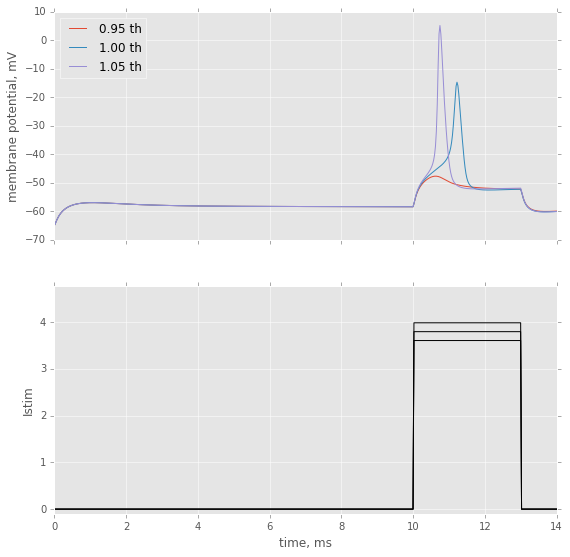

In [197]:
%%time 
plot_around_th(oc, th[0])

In [198]:
from functools import partial

In [199]:
%%time 

fsetter=partial(setup_ramp_stim, Imax=1.5*th[0])
th2 = find_threshold(oc, array([0.5,10.]), 
                     vthresh = -25,
                     setter=fsetter)
print th2

(3.0234375, -23.958638711393032)
CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 651 ms


CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 279 ms


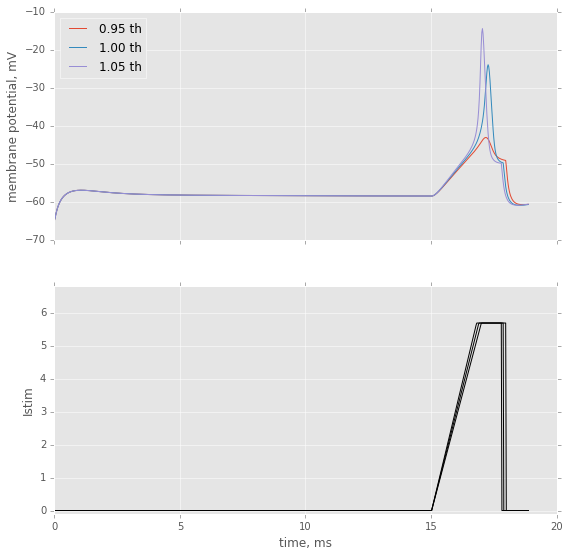

In [200]:
%time plot_around_th(oc, th2[0], setter=fsetter)#, coefs=arange(0.6, 0.7, 0.02))
#for line in gcf().axes[0].lines:
#    setp(line, color='k',alpha=0.5)


(15, 16.5, -60, -45)

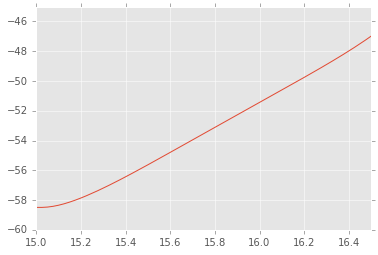

In [201]:
oc.init_records()
h.run()
plot(oc.tv, oc.vax); axis((15,16.5,-60,-45))

In [202]:
atv = array(oc.tv)
av = array(oc.vax)

interv = (atv > 15.2)*(atv<16.2) 
dvr = diff(av[interv])
mean(dvr)/h.dt

8.153515703045672

In [163]:
del oc

## Monte-Carlo look for an admissible range of axonal section lengths

In [19]:
def generate_psets(Ntrials=10,
                   center_act=15.0,
                   center_pass=15.,
                   nhood=15.,
                   variant = 'uniform',
                   domain=[1.0,50.0]):

    active_w = clip(center_act + nhood*array([-1,1]), *domain)
    passive_w = clip(center_act + nhood*array([-1,1]), *domain)
    if variant == 'uniform':
        active_Ls = uniform(*active_w, size=Ntrials)
        passive_Ls = uniform(*passive_w, size=Ntrials)
    elif variant == 'gauss':
        active_Ls = clip(randn(Ntrials)*nhood + center_act, *domain)
        passive_Ls = clip(randn(Ntrials)*nhood + center_pass,*domain)
    psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(active_Ls, passive_Ls)]
    return psets

In [20]:
import sys

In [21]:

def estimate_thresholds(params):
    acc = []
    coef = 1.5
    for k,p in enumerate(params):
        #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
        report =  '\rset #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pth.: {:2.1f} nA, \
rth.: {:2.1f} nA/ms, amp: {:2.1f} mV'
        oc = OctopusCell(Ndendseg=15,**p)
        th1,vsp = find_threshold(oc, array([1, 6]))
        th2 = find_threshold(oc, array([0.5,10.]), setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))[0]

        sys.stderr.write(report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2, vsp))
        acc.append((th1, th2, vsp))
        oc.delete()
        oc = None
        #h('forall delete_section()')
    return array(acc)

In [22]:
def mc_search_parameter_space(Niter=10, Nprime=50,  Next=6, Nbest=3,
                              nhood=2.0, 
                              domain = [(1, 30),(1,50)],
                              max_pulse_th=4.0,
                              min_rate_threshold=4.0,
                              min_peak_vax = -10,
                             ):
    
    
    # Domain corners
    #params = [dict(ax_init_L=l1, ax_passive_L=l2) for l1 in domain[0] for l2 in domain[1]] 
    params = [dict(ax_init_L=l1, ax_passive_L=l2) 
              for l1 in linspace(*domain[0],num=7) 
              for l2 in linspace(*domain[1],num=7)]
    
    # Priming set
    params += generate_psets(Nprime)
    thresholds = estimate_thresholds(params)
    
    def _validate(th):
        return th[0]<=max_pulse_th and th[2]>=min_peak_vax
    
    acc = [(p,t) for p,t in zip(params,thresholds)]
    keep = [(p,t) for p,t in acc if _validate(t)]
    
    
    for i in range(Niter):
        if not len(keep):
            break
        best = sorted(keep, key=lambda p: p[1][1], reverse=True)[:min(len(keep),Nbest)]
        print i, len(acc), best[0]
        #best = permutation(keep)[:min(len(keep),Nbest)]
        
        ukeep = []
        
        params = [generate_psets(Next, pset['ax_init_L'], pset['ax_passive_L'],
                                 nhood=nhood, variant='gauss')
                  for pset,t in keep]
        
        params = list(chain(*params))
        thresholds = estimate_thresholds(params)
        update = [(p,t) for p,t in zip(params, thresholds)]
        acc += update
        ukeep = [(p,t) for p,t in update if _validate(t)]
        keep = ukeep
        
        #for pset,th in keep:
        #    params = generate_psets(Next, pset['ax_init_L'], pset['ax_passive_L'],
        #                            nhood=nhood, variant='gauss')
        #    thresholds = estimate_thresholds(params)
        #    update = [(p,t) for p,t in zip(params, thresholds)]
        #    acc += update
        #    ukeep += [(p,t) for p,t in update if _validate(t)]
        #
        #keep = best + ukeep[:]
    return acc    

In [23]:
import pickle

In [24]:
!ls *.pickle

pspace-explored-003.pickle  pspace-explored-109.pickle
pspace-explored-013.pickle  pspace-explored-181.pickle
pspace-explored-074.pickle


In [26]:
%%time 


gnabars = linspace(1000,5000,15)


psets = [{'ax_init_L':10, 'ax_passive_L':35, 'ax_gbar_na':g, 'ax_gbar_Ikl':5.0} for g in gnabars]
thresholds = estimate_thresholds(psets)

set #13: ax_init: 10.0, ax_pass: 35.0, pth.: 2.1 nA, rth.: 1.1 nA/ms, amp: 40.2 mV

CPU times: user 17.4 s, sys: 12 ms, total: 17.4 s
Wall time: 17.4 s


set #15: ax_init: 10.0, ax_pass: 35.0, pth.: 2.0 nA, rth.: 1.1 nA/ms, amp: 44.3 mV

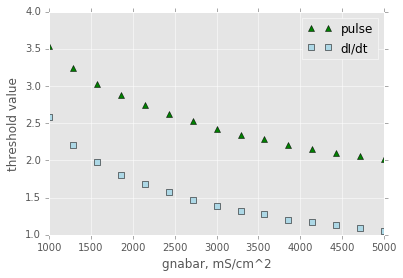

In [27]:
plot(gnabars, [t[0] for t in thresholds], '^',color='green', label='pulse')
plot(gnabars, [t[1] for t in thresholds], 's',color='lightblue',label='dI/dt')
legend()
xlabel('gnabar, mS/cm^2')
ylabel('threshold value')

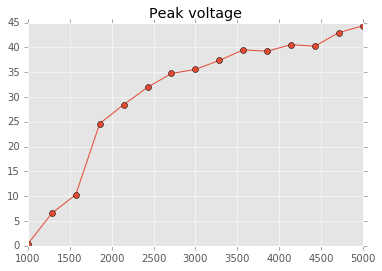

In [28]:
plot(gnabars, [t[2] for t in thresholds], 'o-')
title('Peak voltage')

In [35]:
gklbars = linspace(0,100,25)
psets = [{'ax_init_L':5, 'ax_passive_L':35, 'ax_gbar_na':1600, 'ax_gbar_Ikl':g} for g in gklbars]
thresholds = estimate_thresholds(psets)

set #25: ax_init: 5.0, ax_pass: 35.0, pth.: 4.3 nA, rth.: 3.8 nA/ms, amp: -3.6 mV

(-60, 50)

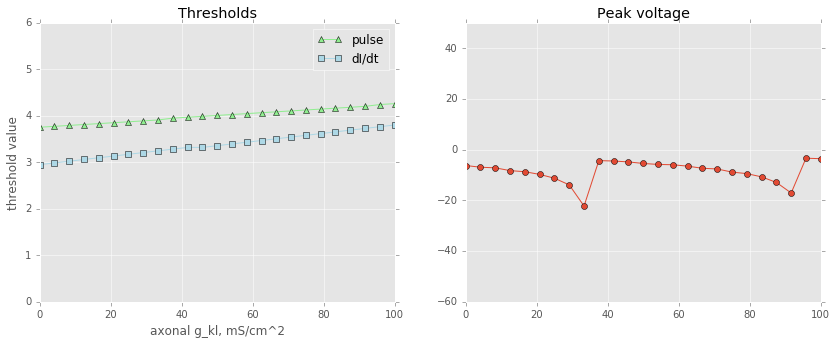

In [36]:
figure(figsize=(14,5))
subplot(121)
title('Thresholds')
plot(gklbars, [t[0] for t in thresholds], '^-',color='lightgreen', label='pulse')
plot(gklbars, [t[1] for t in thresholds], 's-',color='lightblue',label='dI/dt')
legend(loc='best')
xlabel('axonal g_kl, mS/cm^2')
ylabel('threshold value')
ylim(0,6)


subplot(122)
plot(gklbars, [t[2] for t in thresholds], 'o-')
title('Peak voltage')
ylim(-60,50)

In [37]:
%%time

explored = mc_search_parameter_space(Niter=0, Nprime=50, Nbest=10, Next=1)

set #98: ax_init: 21.9, ax_pass: 8.0, pth.: 2.8 nA, rth.: 1.8 nA/ms, amp: 23.7 mV

CPU times: user 1min 54s, sys: 148 ms, total: 1min 54s
Wall time: 1min 54s


set #99: ax_init: 14.8, ax_pass: 14.9, pth.: 3.0 nA, rth.: 2.0 nA/ms, amp: 21.4 mV

In [46]:
%%time 


for d in range(5,50,5):
    for l in range(2, 10,2):
        extended = generate_psets(10, l, d, nhood=2.5, variant='gauss')
        thresholds = estimate_thresholds(extended)

        explored += [(p,t) for p,t in zip(extended, thresholds)]

set #8: ax_init: 6.0, ax_pass: 47.3, pth.: 3.5 nA, rth.: 2.5 nA/ms, amp: 7.3 mV

CPU times: user 7min 4s, sys: 488 ms, total: 7min 5s
Wall time: 7min 4s


set #10: ax_init: 9.0, ax_pass: 42.7, pth.: 3.1 nA, rth.: 2.1 nA/ms, amp: 19.4 mV

In [84]:
%%time 
extended = generate_psets(10, 4, 35, nhood=2.5, variant='gauss')
thresholds = estimate_thresholds(extended)
explored += [(p,t) for p,t in zip(extended, thresholds)]

set #9: ax_init: 4.9, ax_pass: 35.8, pth.: 3.8 nA, rth.: 3.0 nA/ms, amp: -7.1 mV

CPU times: user 11.7 s, sys: 8 ms, total: 11.7 s
Wall time: 11.7 s


set #10: ax_init: 7.5, ax_pass: 37.8, pth.: 3.3 nA, rth.: 2.3 nA/ms, amp: 12.0 mV

In [85]:
pickle.dump(explored, open('pspace-explored-%03d.pickle'%randint(1000),'w'))
#explored = pickle.load(open('pspace-explored-181.pickle'))

In [86]:
#Ntrials = 100
#axinit_Ls = uniform(2, 30, size=Ntrials)
#axstub_Ls = uniform(2, 30, size=Ntrials)

#psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(axinit_Ls, axstub_Ls)]

In [87]:
#%%time 
#rate_ths = []
#pulse_ths = []
#coef = 2
#for k,p in enumerate(psets):
#    #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
#    report =  'set #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pulse th.: {:2.1f}, rate th.: {:2.1f}'
#    oc = OctopusCell(Ndendseg=20,**p)
#    th1 = find_threshold(oc, array([1, 6]))
#        
#    th2 = find_threshold(oc, array([0.5,10.]), 
#                         setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))

#    print report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2)
#    pulse_ths.append(th1)
#    rate_ths.append(th2)
#    oc = None

In [88]:
from matplotlib.mlab import griddata

In [89]:
#explored

In [90]:
xi = np.linspace(1, 30, 200)
yi = np.linspace(1, 50, 200)
# grid the data.

x = [_p['ax_init_L'] for _p,_e in explored]
y = [_p['ax_passive_L'] for _p,_e in explored]

z1,z2,z3 = [[_e[k] for _p,_e  in explored] for k in range(3)]

zi1,zi2,zi3 = [griddata(x, y, z, xi, yi, interp='linear') for z in (z1,z2,z3)]

[None]

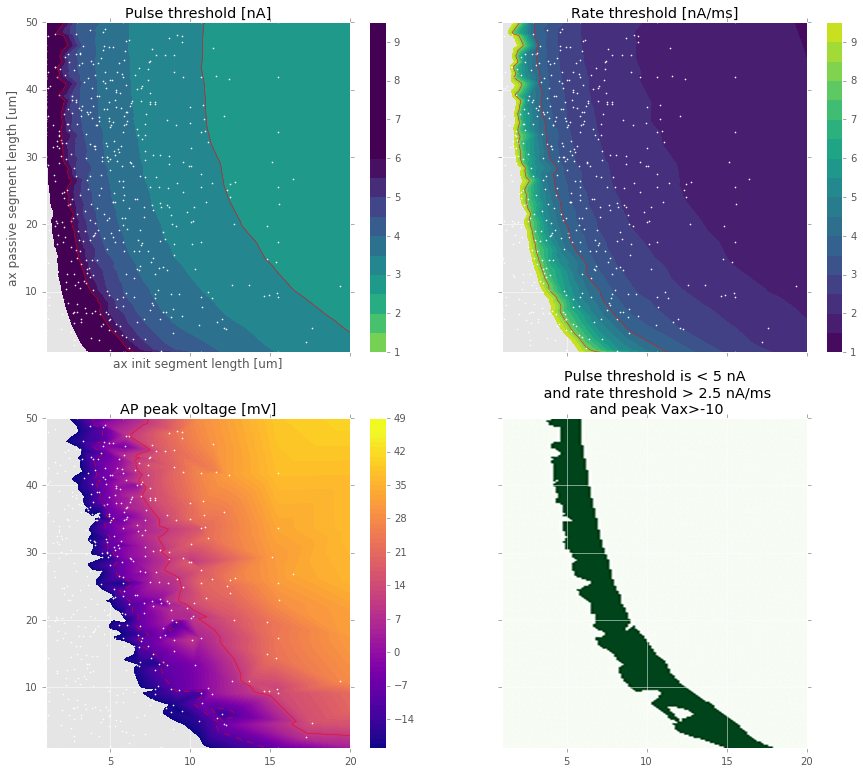

In [133]:
f, axs = subplots(2,2, sharex=True, sharey=True, figsize=(15,13))

axs = ravel(axs)

CS = axs[0].contour(xi, yi, zi1, [3,6], linewidths=0.5, colors='r')
CS = axs[0].contourf(xi, yi, zi1, arange(1,10,0.5), cmap='viridis_r', vmax=6.0, vmin=0)
plt.colorbar(CS,ax=axs[0])  # draw colorbar

axs[0].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[0], title ='Pulse threshold [nA]', xlabel='ax init segment length [um]',
     ylabel='ax passive segment length [um]')



CS = axs[1].contour(xi, yi, zi2, [4,8], linewidths=0.5, colors='r')
CS = axs[1].contourf(xi, yi, zi2, arange(1,10,0.5), vmax=10, cmap='viridis')
plt.colorbar(CS,ax=axs[1])  # draw colorbar

axs[1].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[1], title ='Rate threshold [nA/ms]')


CS = axs[2].contour(xi, yi, zi3, [-10,10], linewidths=0.5, colors='r')
CS = axs[2].contourf(xi, yi, zi3, arange(-20,50), cmap='plasma', vmax=amax(z3), vmin=-20)
plt.colorbar(CS,ax=axs[2])  # draw colorbar

axs[2].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[2], title ='AP peak voltage [mV]')



admiss = (zi2 > 2.5)*(zi1 < 5)*(zi3>-10)
cs = axs[3].imshow(admiss, extent=(1,30,1,50),cmap='Greens', origin='lower')
setp(axs[3], title = "Pulse threshold is < 5 nA\n and rate threshold > 2.5 nA/ms\n and peak Vax>-10")
a = plt.colorbar(cs,ax=axs[3])  # draw colorbar

#xlabel('ax init segment len [um]')
#ylabel('ax passive segment len [um]')

setp(axs[2], xlim=(1,20), ylim=(1,50))
setp(gcf().axes[-1],visible=False)

In [134]:

mx = amax(zi2*admiss)
print mx

row,col = where(mx==zi2*admiss)

print xi[col],yi[row], zi3[row[0],col[0]]

3.45669620628
[ 3.76884422] [ 49.50753769] -9.89217352787


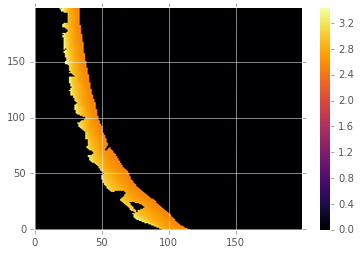

In [132]:
imshow(zi2*admiss,origin='lower',cmap='inferno');colorbar()

## Energy calc

In [18]:
def split_mixed(v, gm, erev,ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh


def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def J2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3



def mouj_Erate2(seg, erev_ih = -38):
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.gh_ihsab, erev_ih, seg.ek, seg.ena) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

## Adding synapses

In [11]:
oc1.delete()
oc2.delete()
oc.delete()
del oc1, oc2, oc

NameError: name 'oc1' is not defined

In [10]:
h.topology()

1.0

In [27]:
#oc1 = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
oc2 = OctopusCell(ax_init_L = 5., ax_passive_L = 35)

Nsyn = 252
gsyn = 1.1
rate = 256.


oc2.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy='random')
#[oc.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy=ton) 
# for oc,ton in ((oc1, 'ordered'), (oc2,'random'))]


print 'done'

done


In [13]:
h.cvode_active(0)
h.dt = 0.005
#h.cvode_active(1)
#print h.cvode.atol()
#h.cvode.atol(5e-4)

In [14]:
#

In [28]:
#oc1.init_records()
def trial_run():
    oc2.init_records()
    h.tstop = 500
    h.v_init = -60.0
    %time h.run()
    return map(array, (oc2.tv, oc2.vax))



Сравним разные методы интегрирования: с фиксированным шагом при разном $dt$ и с адаптивным шагом при разном $atol$. При этом клетка со случайно разбросанными синапсами одна и та же.

In [29]:
h.cvode_active(0)
dtfix = (0.02, 0.01, 0.005)

fixed = []
for dt in dtfix:
    h.dt = dt
    fixed.append(trial_run())

CPU times: user 18.4 s, sys: 0 ns, total: 18.4 s
Wall time: 18.4 s
CPU times: user 36.6 s, sys: 0 ns, total: 36.6 s
Wall time: 36.6 s
CPU times: user 1min 31s, sys: 0 ns, total: 1min 31s
Wall time: 1min 31s


In [39]:
h.cvode_active(1)

atols = (1e-2, 1e-3, 5e-4, 1e-4)

adaptive = []
for atol in atols:
    h.cvode.atol(atol)
    adaptive.append(trial_run())

CPU times: user 44.7 s, sys: 0 ns, total: 44.7 s
Wall time: 44.7 s
CPU times: user 57.4 s, sys: 0 ns, total: 57.4 s
Wall time: 57.4 s
CPU times: user 1min, sys: 4 ms, total: 1min
Wall time: 1min
CPU times: user 1min 30s, sys: 4 ms, total: 1min 30s
Wall time: 1min 30s


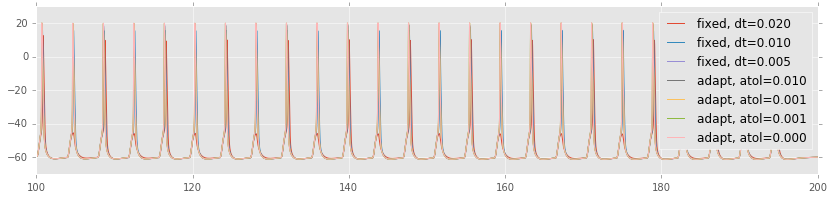

In [46]:
figure(figsize=(14,3))

for (tv,av),dt in zip(fixed, dtfix):
    plot(tv, av, label='fixed, dt=%0.3f'%dt)
    
for (tv,av),at in zip(adaptive, atols):
    plot(tv, av, label='adapt, atol=%0.3f'%at)


xlim(100,200)    
legend()


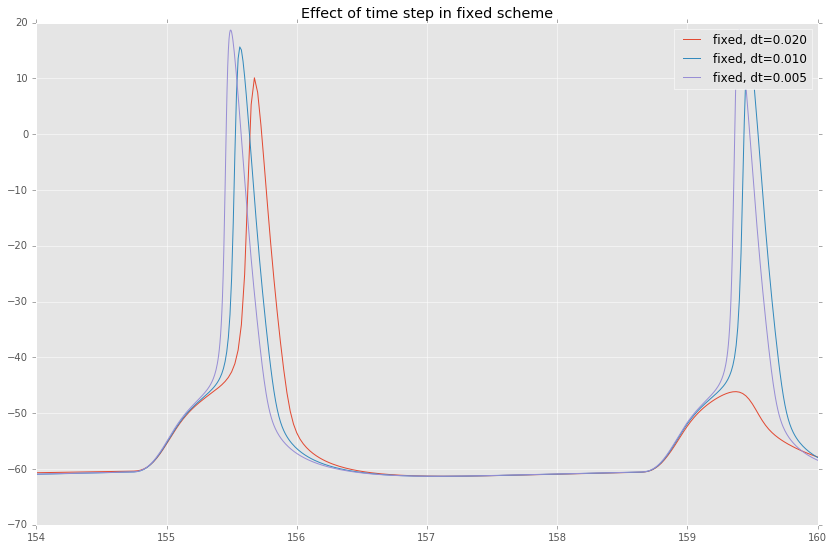

In [47]:
figure(figsize=(14,9))

for (tv,av),dt in zip(fixed, dtfix):
    plot(tv, av, label='fixed, dt=%0.3f'%dt)
    
title('Effect of time step in fixed scheme')
    
xlim(154,160)    
legend()


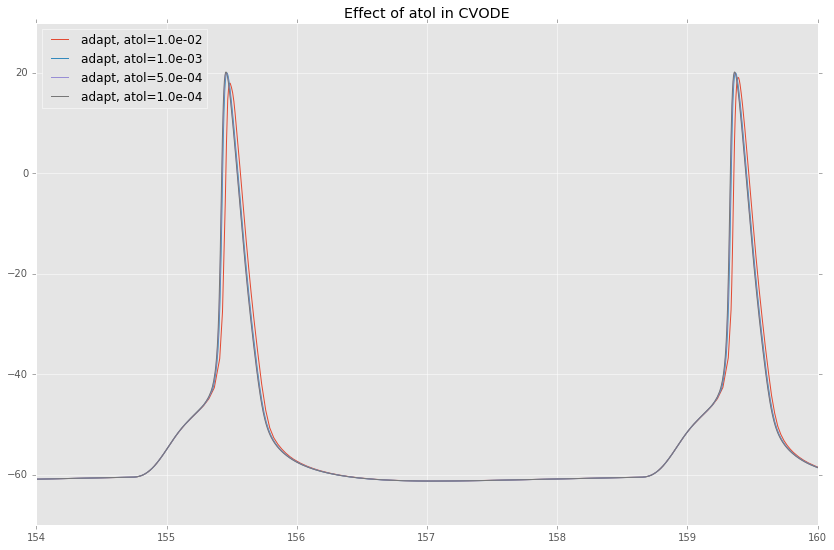

In [51]:
figure(figsize=(14,9))

for (tv,av),at in zip(adaptive, atols):
    plot(tv, av, label='adapt, atol=%0.1e'%at)

title('Effect of atol in CVODE')
xlim(154,160)    
legend(loc='best')


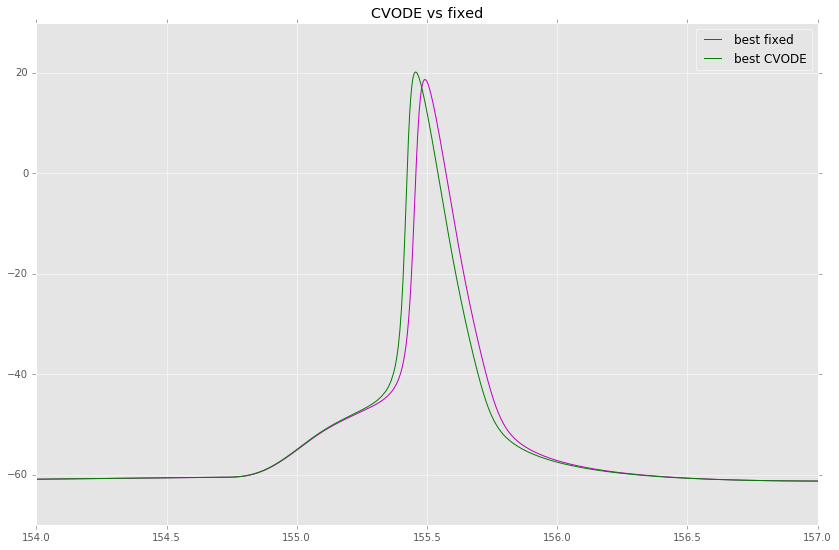

In [55]:
figure(figsize=(14,9))

title('CVODE vs fixed')
plot(*fixed[-1],color='m',label='best fixed')
plot(*adaptive[-1],color='g',label='best CVODE')
legend(loc='best')
xlim(154,157)    
legend(loc='best')

**Вывод:** *При исследовании синаптических входов будем использовать **CVODE с atol=1e-3***

In [60]:
oc2.delete()
del oc2

In [7]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [8]:
h.topology()

1.0

In [35]:

gsyn = 1.0
rate = 256.
npulses = 25.

def count_synapses(Nsynv, gsyn=1.0, rate=256., npulses=25.,tonotopy='ordered'):
    acc = []
    for Nsyn in Nsynv:
        oc = OctopusCell(ax_init_L = 5., ax_passive_L = 35)
        oc.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy=tonotopy)
        apc = h.APCount(oc.ax_init(0.5), )
        apc.thresh=-20
        h.tstop = 500
        h.v_init = -60.0
        h.run()
        sys.stderr.write('\r%d synapses, spike ratio: %0.2f'%(Nsyn, apc.n/npulses))
        acc.append([Nsyn, apc.n/npulses])
        oc.delete()
        del oc, apc    
    return acc


In [10]:
%time acc = count_synapses(range(225,256))
nsyns,counts = array(sorted(acc, key=lambda _e: _e[0])).T


225 synapses, spike ratio: 0.00
226 synapses, spike ratio: 0.00
227 synapses, spike ratio: 0.00
228 synapses, spike ratio: 0.00
229 synapses, spike ratio: 0.00
230 synapses, spike ratio: 0.00
231 synapses, spike ratio: 0.00
232 synapses, spike ratio: 0.00
233 synapses, spike ratio: 0.04
234 synapses, spike ratio: 0.04
235 synapses, spike ratio: 0.04
236 synapses, spike ratio: 0.04
237 synapses, spike ratio: 0.04
238 synapses, spike ratio: 0.04
239 synapses, spike ratio: 0.04
240 synapses, spike ratio: 0.04
241 synapses, spike ratio: 0.04
242 synapses, spike ratio: 0.52
243 synapses, spike ratio: 0.52
244 synapses, spike ratio: 0.52
245 synapses, spike ratio: 0.52
246 synapses, spike ratio: 0.80
247 synapses, spike ratio: 1.00
248 synapses, spike ratio: 1.00
249 synapses, spike ratio: 1.00
250 synapses, spike ratio: 1.00
251 synapses, spike ratio: 1.00
252 synapses, spike ratio: 1.00
253 synapses, spike ratio: 1.00
254 synapses, spike ratio: 1.00
255 synapses, spike ratio: 1.00
CPU time

In [23]:
h.topology()

1.0

In [39]:
acc_r1 = [count_synapses(range(240,302,2),tonotopy='random') for i in range(10)]
nsynsr,countsr = mean(acc_r1,axis=0).T

300 synapses, spike ratio: 1.00

(-0.1, 1.1)

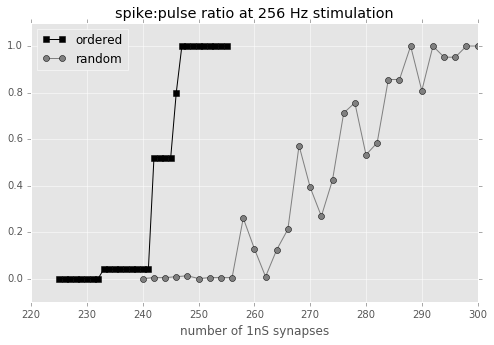

In [40]:
figure(figsize=(8,5))
plot(nsyns,counts, 'ks-', label='ordered')
plot(nsynsr,countsr, 'o-', color='gray', label='random')
title('spike:pulse ratio at 256 Hz stimulation')
legend(loc='best')
xlabel('number of 1nS synapses')
ylim(-0.1,1.1)

## Run control from Python and energy accounting

In [ ]:
#axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33

In [13]:
h.cvode_active(1)
h.cvode.atol(1e-3)

0.001

In [50]:
h.dt = 0.01
tstop = 300

h.v_init = -60.6

def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

    
def instant_erates(cell):
    syn_erate = np.sum([synaptic_curr2pJ(s,dseg) for s,c,dseg in cell.synapses])
    soma_erate = mouj_Erate2(cell.soma(0.5))
    dend_erate = np.sum([mouj_Erate2(seg) for seg in chain(*cell.dendrites)])
    axon_erate = np.sum([mouj_Erate2(seg) for seg in chain(cell.ax_init,cell.ax_stub)])
    return axon_erate, soma_erate, dend_erate, syn_erate
    
    
def integrate_collecting_energy(cells):

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate']
    outs = [{key:[] for key in keepvar} for i in range(len(cells))]

    while h.t < tstop:
        h.fadvance()
        #isyn = np.sum([syn.i for syn in synapses])
        
        erates = map(instant_erates, cells)
        
        for cell, o, erate in zip(cells, outs, erates):
            o['t'].append(h.t)
            o['axon.v'].append(cell.ax_init.v)
            o['soma.v'].append(cell.soma.v)
            o['axon.erate'].append(erate[0])
            o['soma.erate'].append(erate[1])
            o['dend.erate'].append(erate[2])
            o['syn.erate'].append(erate[3])
        sys.stderr.write('\r model time: %0.5f ms '%h.t)
    sys.stderr.write('\r                                         \r\n')

    return [{key:np.array(vec) for key,vec in out.items()} for out in outs]

def go(cells):
    initialize()
    return integrate_collecting_energy(cells)
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].legend()

In [61]:
oc1.delete()
oc2.delete()
del oc1, oc2
h.topology()

1.0

In [62]:
oc1,oc2 = OctopusCell(),OctopusCell()

rate = 256.
oc1.add_synapses(tonotopy='ordered',gsyn=1.0, Nsyn=250, aud_rate=rate)
oc2.add_synapses(tonotopy='random',gsyn=1.0, Nsyn=290, aud_rate=rate)


In [63]:
%time data = go([oc1,oc2])

 model time: 246.11800 ms 

CPU times: user 8min 48s, sys: 29.9 s, total: 9min 18s
Wall time: 8min 16s


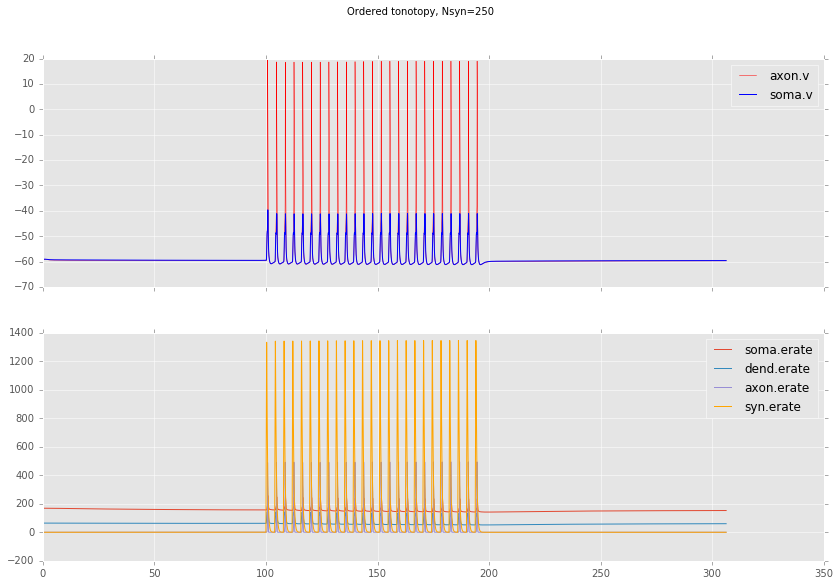

In [64]:
plot_traj(data[0])
suptitle('Ordered tonotopy, Nsyn=250')

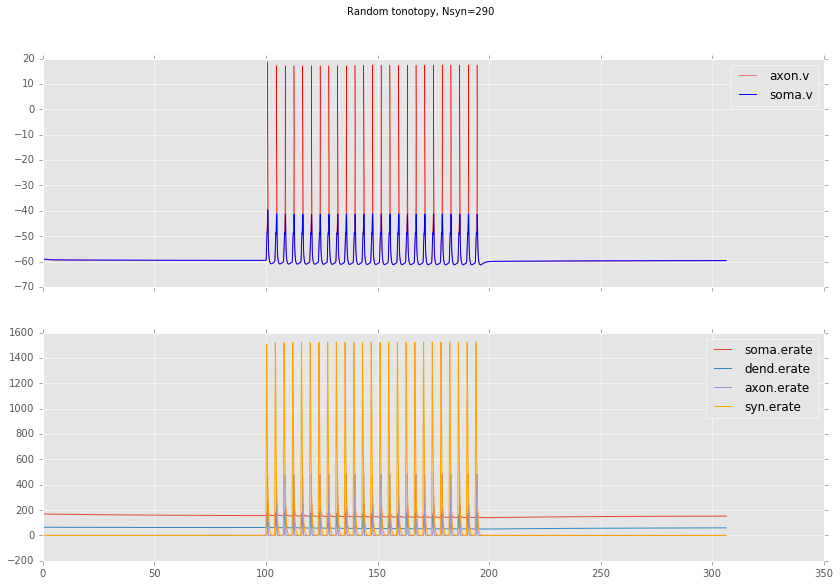

In [75]:
plot_traj(data[1])
suptitle('Random tonotopy, Nsyn=290')

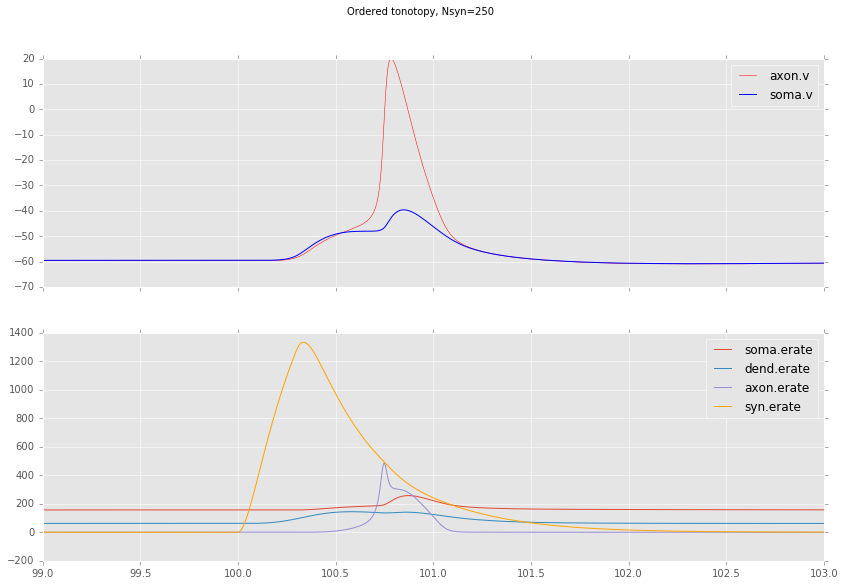

In [72]:
plot_traj(data[0])
xlim(99, 103)
suptitle('Ordered tonotopy, Nsyn=250')

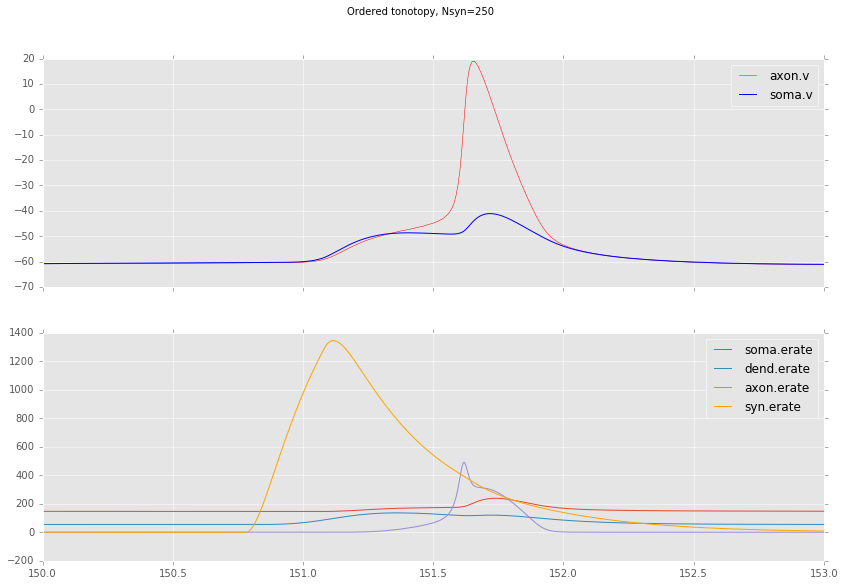

In [73]:
plot_traj(data[0])
xlim(150, 153)
suptitle('Ordered tonotopy, Nsyn=250')

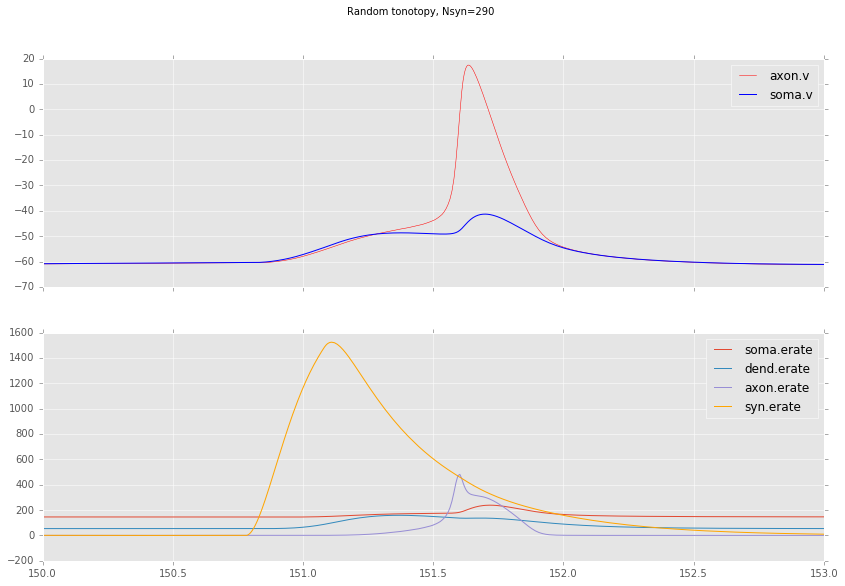

In [74]:
plot_traj(data[1])
xlim(150, 153)
suptitle('Random tonotopy, Nsyn=290')

In [69]:
oc1_traj,oc2_traj = data

(150, 153)

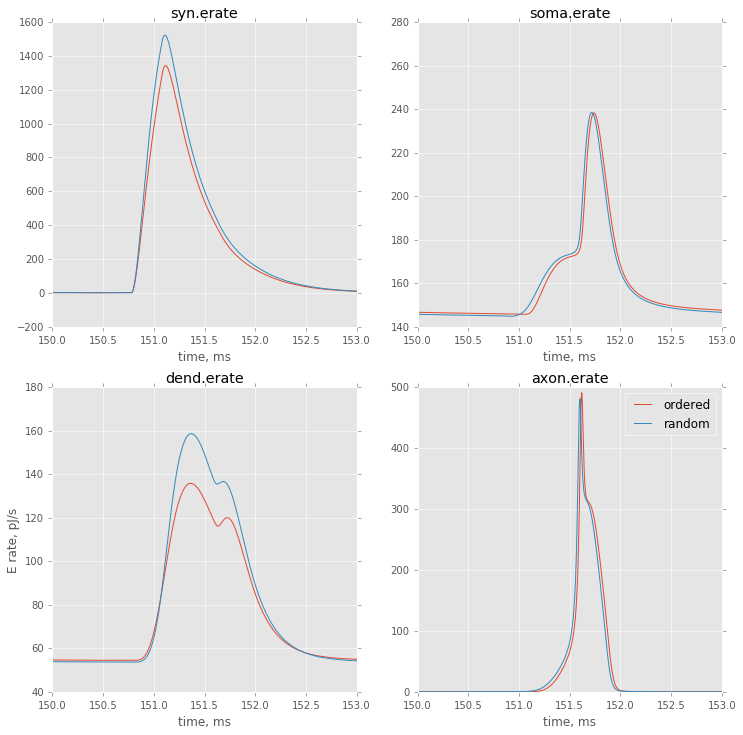

In [70]:
figure(figsize=(12,12))
subplot(2,2,3)
plot(oc1_traj['t'], oc1_traj['dend.erate'], label='ordered')
plot(oc2_traj['t'], oc2_traj['dend.erate'], label='random')
title('dend.erate')
xlabel('time, ms')
ylabel('E rate, pJ/s')

xlim(150, 153)

subplot(2,2,2)
plot(oc1_traj['t'], oc1_traj['soma.erate'], label='ordered')
plot(oc2_traj['t'], oc2_traj['soma.erate'], label='random')
title('soma.erate')
xlabel('time, ms')
#ylabel('E rate, pJ/s')
#legend()
xlim(150, 153)


subplot(2,2,1)
plot(oc1_traj['t'], oc1_traj['syn.erate'], label='ordered')
plot(oc2_traj['t'], oc2_traj['syn.erate'], label='random')
title('syn.erate')
xlabel('time, ms')
#ylabel('E rate, pJ/s')
#legend()
xlim(150, 153)


subplot(2,2,4)
plot(oc1_traj['t'], oc1_traj['axon.erate'], label='ordered')
plot(oc2_traj['t'], oc2_traj['axon.erate'], label='random')
title('axon.erate')
xlabel('time, ms')
#ylabel('E rate, pJ/s')
legend()
xlim(150, 153)